In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from data import *
import pretrainedmodels
import torchvision.transforms as transforms
import sys
import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import json
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
nw = 4   #number of workers for data loader
# TOT = 46613580 - 340000

NCATS = 340
NUM_EACH_CLASS = 50000
TOT = NCATS * NUM_EACH_CLASS
EPOCHS = 50
size = 224
SIZE = size # for matching to imagenet
batchsize = 48 
lw = 6
STEPS = int(NUM_EACH_CLASS * NCATS / EPOCHS / batchsize)

channel = 3

device = torch.device("cuda:0")

In [3]:
en_dict = {}
path = '../input/train_simp/'

filenames = glob.glob(os.path.join(path, '*.csv'))
filenames = sorted(filenames)

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
        
# collect file names and encode label
encode_files()

dec_dict = {v: k for k, v in en_dict.items()}
def decode_labels(label):
    return dec_dict[label]

def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]

In [4]:
class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        img = draw_cv2_parts(raw_strokes, size = size, lw = lw)
        return np.transpose(img, (2, 0, 1))
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = json.loads(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=6, time_color=True)
        if self.transform:
            sample = self.transform(sample)
#         print(sample.shape, sample[None].shape)
        if self.mode == 'train':
            return (sample/255).astype('float32'), self.label
        else:
            return (sample/255).astype('float32')

In [5]:

# collect all single csvset in one
select_nrows = NUM_EACH_CLASS
skip_rows = 0
doodle_all = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=select_nrows, size=SIZE,
                                          ) for fn in filenames])

In [6]:
# select some rows for validation
valid_rows = 100
validationset = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=valid_rows, size=SIZE,
                                           skiprows=range(1, skip_rows + select_nrows)) for fn in filenames])

In [7]:
# total images in set
print('Train set:', len(doodle_all))
print('Validation set:', len(validationset))
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(doodle_all, batch_size=batchsize, shuffle=True, num_workers=4)
valid_loader = DataLoader(validationset, batch_size=16, shuffle=False, num_workers=4)

Train set: 17000000
Validation set: 34000


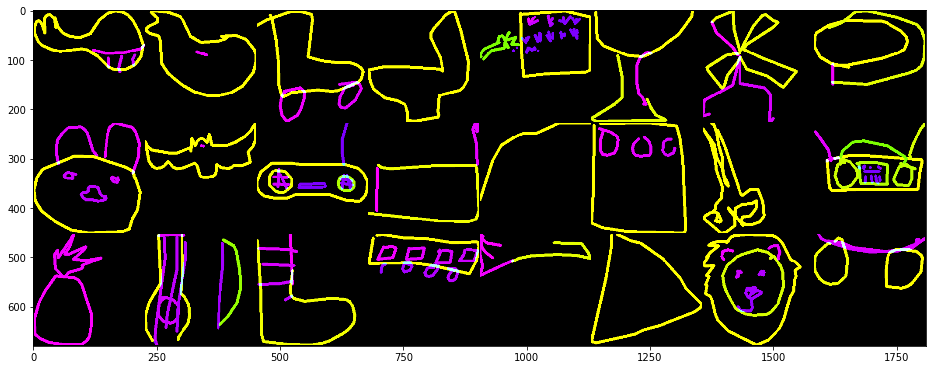

In [8]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images 
dataiter = iter(loader)
images, label = dataiter.next()

# show images
plt.figure(figsize=(16,24))
imshow(torchvision.utils.make_grid(images[:24]))

In [9]:
images.shape

torch.Size([48, 3, 224, 224])

In [10]:
# validation function 
def validation(lossf, scoref):
    model.eval()
    loss, score = 0, 0
    vlen = len(valid_loader)
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss += lossf(output, y).item()
        score += scoref(output, y)[0].item()
    model.train()
    return loss/vlen, score/vlen

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [11]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [12]:
model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained='imagenet')
model.last_linear = nn.Linear(in_features = 2048, out_features = NCATS)

In [13]:
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   model = nn.DataParallel(model)

In [14]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.002)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience = 2)

model = model.to(device)

In [15]:
MODEL_CKPT = 'models/best_se_resnext50_parts_all.pth'

In [ ]:
epochs = 2
lsize = len(loader)
itr = 1
p_itr = int(lsize / 150) # print every N iteration
patience = 5

print('p_itr', p_itr)

# if os.path.exists(MODEL_CKPT):
#     print('load previous trained weights', MODEL_CKPT)
#     model.load_state_dict(torch.load(MODEL_CKPT, map_location=lambda storage, loc: storage))
model.train()

best_loss = 999.0
lr_patient = 0
valid_patient = 0
cycle = 0
lr_min = 0.0001
lr_max = 0.002
lr_rampdown = 65

for epoch in range(epochs):
    tloss, score = 0, 0
    for x, y in tqdm_notebook(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
        score += accuracy(output, y)[0].item()
        if itr%p_itr==0:
            vloss, vscore = validation(criterion, accuracy)
            print('Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(itr, tloss/p_itr, score/p_itr))
            print('Iteration {} -> Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(itr, vloss, vscore))
            time.sleep(0.1)
            
#             exp_lr_scheduler.step(vscore)
            
            if vloss < best_loss:
                lr_patient = 0
                valid_patient = 0
                best_loss = vloss
                
                model.eval()
                torch.save(model.state_dict(), MODEL_CKPT)
                model.train()
                
                print('new best_score{:.3f}'.format(vscore), 'save to', MODEL_CKPT)
            else:
                lr_patient += 1
                valid_patient += 1
                
            if valid_patient > 15:
                cycle += 1
                lr_patient = 0
                valid_patient = 0
                
                checkpath = 'models/se_resnext50_parts_cycle{}.pth'.format(cycle)
                model.eval()
                torch.save(model.state_dict(), checkpath)
                model.train()

                print('rampdown')
                for params in optimizer.param_groups:
                    params['lr'] = (lr_min + 0.5 * (lr_max - lr_min) *
                                   (1 + np.cos(np.pi * t_ / lr_rampdown)))

                print('Learning rate set to {:.4}'.format(optimizer.param_groups[0]['lr']))

            if lr_patient > patience:
                print('Reducing learning rate by {}'.format(0.5))
                for params in optimizer.param_groups:
                    params['lr'] *= 0.5
                lr_patient = 0
                
            tloss, score = 0, 0
             
        itr +=1
vloss, vscore = validation(criterion, accuracy)
print('Final -> Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(vloss, vscore))

p_itr 2361


Iteration 2361 -> Train Loss: 3.3174, Accuracy: 29.77%
Iteration 2361 -> Validation Loss: 2.0315, Accuracy: 51.94%
new best_score51.938 save to models/best_se_resnext50_parts_all.pth
Iteration 4722 -> Train Loss: 1.7873, Accuracy: 57.22%
Iteration 4722 -> Validation Loss: 1.5608, Accuracy: 62.20%
new best_score62.203 save to models/best_se_resnext50_parts_all.pth
Iteration 7083 -> Train Loss: 1.5207, Accuracy: 62.98%
Iteration 7083 -> Validation Loss: 1.4186, Accuracy: 65.41%
new best_score65.415 save to models/best_se_resnext50_parts_all.pth
Iteration 9444 -> Train Loss: 1.3935, Accuracy: 65.89%
Iteration 9444 -> Validation Loss: 283.1415, Accuracy: 0.29%
Iteration 11805 -> Train Loss: 1.3098, Accuracy: 67.71%
Iteration 11805 -> Validation Loss: 2921.7564, Accuracy: 0.29%
Iteration 14166 -> Train Loss: 1.2451, Accuracy: 69.20%
Iteration 14166 -> Validation Loss: 1462.8494, Accuracy: 0.29%
Iteration 16527 -> Train Loss: 1.2231, Accuracy: 69.53%
Iteration 16527 -> Validation Loss: 1.194

In [ ]:
model.load_state_dict(torch.load(MODEL_CKPT, map_location=lambda storage, loc: storage))
model.eval() 

In [ ]:
testset = DoodlesDataset('test_simplified.csv', '../input', mode='test', nrows=None, size=SIZE)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
labels = np.empty((0,3))
for x in tqdm_notebook(testloader):
    x = x.to(device)
    output = model(x)
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred], axis = 0)

In [ ]:
submission = pd.read_csv('../input/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
prog = tqdm_notebook(total = len(submission))
for i, label in enumerate(labels):
    prog.update(1)
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

In [ ]:
import kaggle_util
kaggle_util.save_result(submission,  
                        '../result/se-resnet50.csv', 
                         'quickdraw-doodle-recognition', 
                        send=True, index=True)